In [33]:
#pip install cookiecutter
#!pip install yellowbrick

# Solution Planning

In [34]:
# Input

1. Business Problem

    Selecting the most valuable customers to join a fidelization program

2. Data

    E-commerce sales during a year

In [35]:
# Output

1. List of customer will be part of insider program

    client_id  |  is_insider
     10323     |  yes

In [36]:
# Task

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegivel? O que são clientes de maior 'valor'?
    - Faturamento:
        - Alto Ticket Médio
        - Alto LTV
        - Baixa recência
        - Alto basket size
        - Baixa probabilidade de churn
        - Alta previsão de LTV
        - Alta propensão de compra
        
    - Custo:
        - Baixa taxa de devolução
        
    - Experiencia de compra:
        - Média alta das avaliações
        
2. Quantos clientes farão parte do grupo?
    - Número total de clientes
    - % do grupo insiders
    
3. Quais as principais características desses clientes ?
    - Escrever características dos clientes:
        - Idade
        - Localização
        
    - Escrever características do consumo
        - Atributos de clusterizaçao

4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Faturamento total do ano
    - Faturamento do grupo Insiders
    
    
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Análise Cohort
    
6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa grupo
        
7. Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa nao é ser similar ou parecido com uma pessoa grupo
    
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses
    
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferencia de compra
    - Visita a empresa

Benchmark de soluções

# Imports

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import cluster as c
from sklearn import metrics as m

from matplotlib import pyplot as plt
from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Helper Functions

# Data Import

In [38]:
#load data
df = pd.read_csv('Ecommerce.csv',encoding="ISO-8859-1")

#drop
df = df.drop(columns=['Unnamed: 8'], axis=1)

# 1.0 Data Description

In [39]:
df1 = df.copy()

## 1.1. Rename Columns 

In [40]:
cols_new = df1.columns

cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']

df1.columns = cols_new

## 1.2. Data Dimensions

In [41]:
print('Number of columns: ', df1.shape[1])
print('Number of rows: ', df1.shape[0])

Number of columns:  8
Number of rows:  541909


## 1.3. Data Type

In [42]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. NA Check

In [43]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [44]:
df1 = df1.dropna(subset=['description', 'customer_id'])
print('% dataset removed: {:.2f}'.format(1 - (df1.shape[0]/df.shape[0])))

% dataset removed: 0.25


## 1.6. Change Types

In [45]:
#df1['invoice_no'] = df1['invoice_no'].replace(to_replace='\D', value='', regex=True)
#df1['stock_code'] = df1['stock_code'].replace(to_replace='\D', value='0', regex=True)

In [46]:
#df1.loc[df1['stock_code'] == '85123A']
#df1 = df1.replace(['C536383','C536379','C536391','C536506'],['536383','536379','536391','536506'])

In [47]:
#invoice data
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format= '%d-%b-%y')

#customer id
df1['customer_id'] = df1['customer_id'].astype(int)

#invoice no
#df1['invoice_no'] = df1['invoice_no'].astype(int)

#stock code
#df1['stock_code'] = df1['stock_code'].astype(int)

## 1.7. Descriptive Statistics

# 2.0 Feature Engineering

In [48]:
df2 = df1.copy()

## 2.1. Feature Creation

In [49]:
df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 'quantity',
              'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

#gross revenue
df2['gross_revenue'] = df2['quantity']*df2['unit_price']

#monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

#recency
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

#frequency
df_freq = df2[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

#average ticket
df_avg_ticket = df2[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref,df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
dtype: int64

# 3.0 Variable Filtering

In [50]:
df3 = df_ref.copy()

# 4.0 EDA

In [51]:
df4 = df3.copy()

# 5.0 Data Preparation

In [52]:
df5 = df4.copy()

# 6.0 Feature Selection

In [53]:
df6 = df5.copy()

In [54]:
print('Number of rows: ', df2.shape[0])

Number of rows:  406829


# 7.0 Hyperparameter Fine-Tuning

In [55]:
X = df6.drop(columns = 'customer_id')

clusters = [2, 3, 4, 5, 6, 7, 8]

## 7.1 Within-Cluster Sum of Square (WSS)

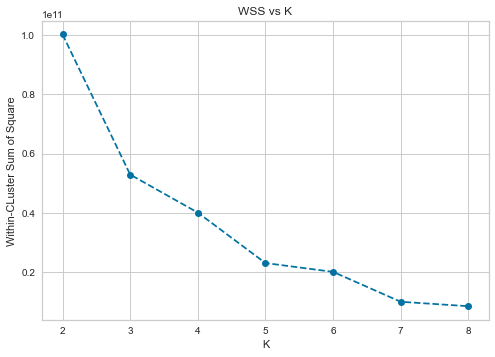

In [56]:
wss = []
for k in clusters:
    #model
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    #model training
    kmeans.fit(X)
    
    #validation
    wss.append(kmeans.inertia_)

#plot wss - Elbow Method
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Within-CLuster Sum of Square');
plt.title('WSS vs K');

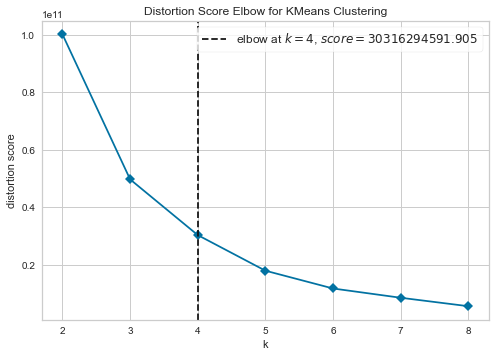

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [57]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings = False)
kmeans.fit(X)
kmeans.show()

## 7.2. Silhouette Score (SS)

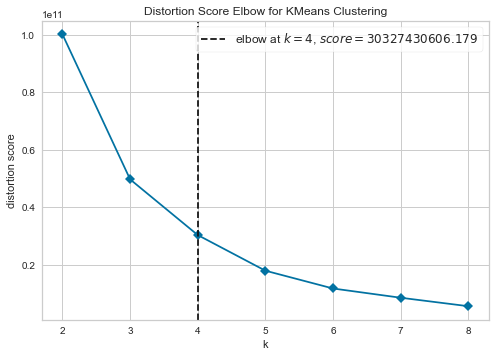

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [58]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metrics='silhouette', timings = False)
kmeans.fit(X)
kmeans.show()

## 7.2. Silhouette Analysis

IndexError: index 3 is out of bounds for axis 0 with size 3

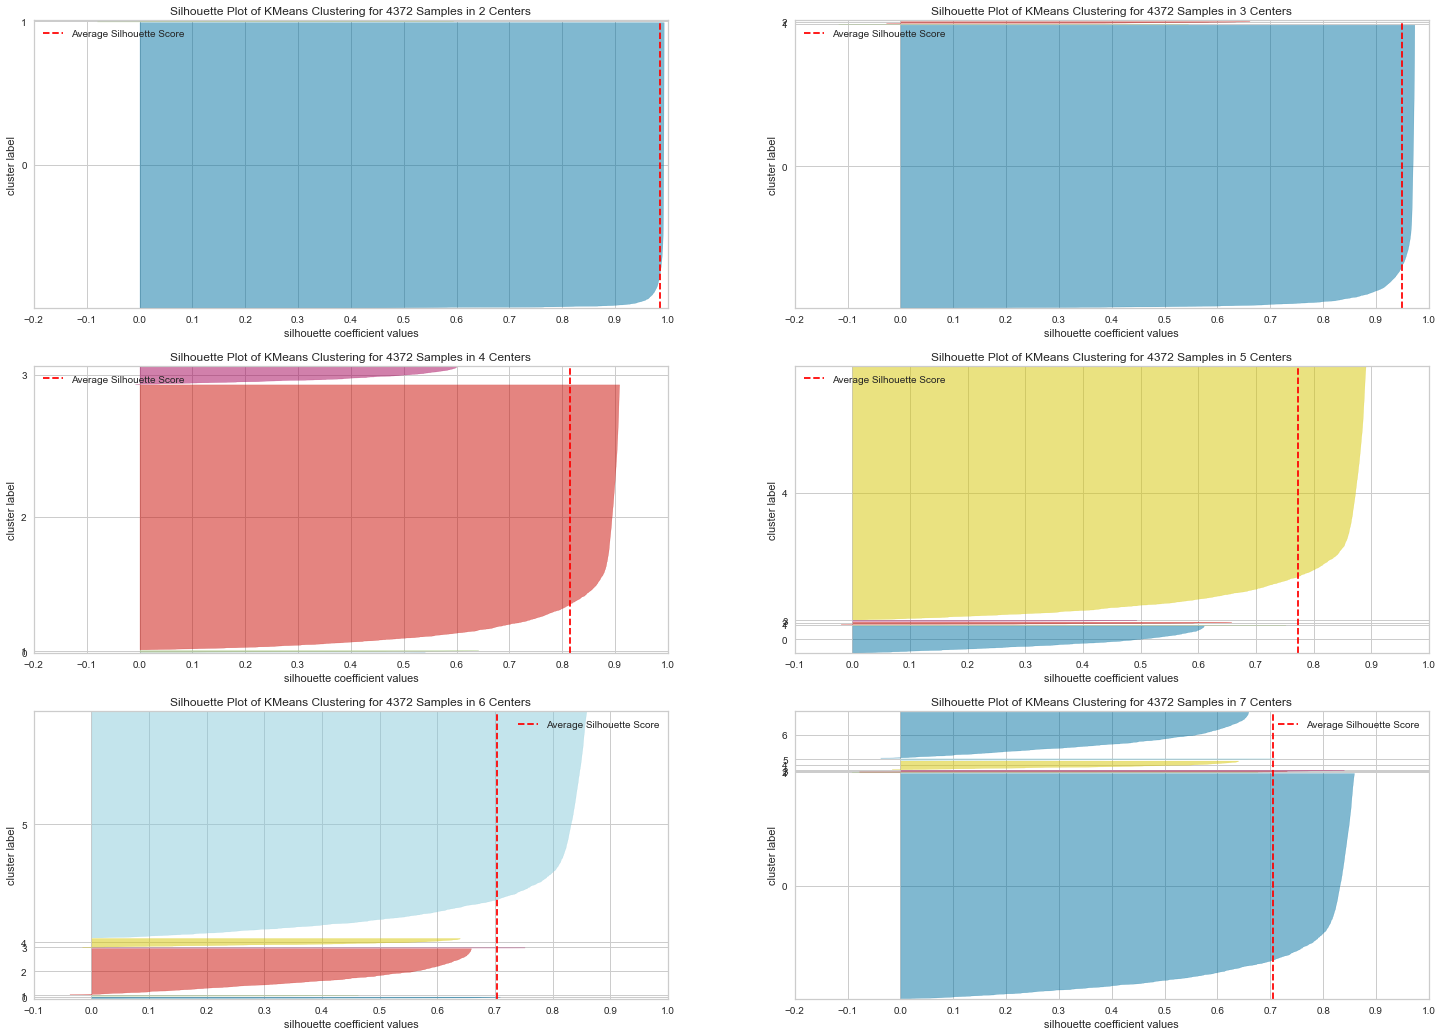

In [65]:
fig, ax = plt.subplots(3,2, figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k,2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0 Model Training

## 8.1. K-Means

In [66]:
k = 4

#model
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
   
#model training
kmeans.fit(X)
    
#clustering
labels = kmeans.labels_

In [67]:
#WSS
print('WSS value: {}'.format(kmeans.inertia_))

#SS
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value: 40056254626.30001
SS value: 0.8139972028952444


# 9.0 Cluster Analysis

In [68]:
df9 = df6.copy()
df9['cluster'] = labels

## 9.1. Cluster Visualization

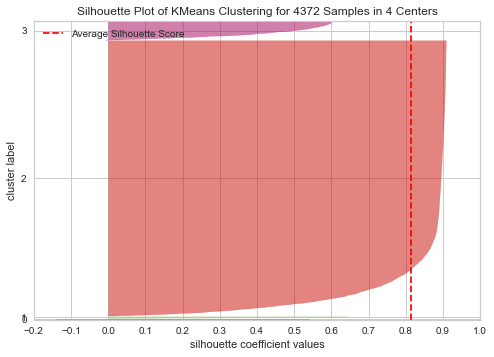

In [69]:
#fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
#fig.show()

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2. 2d

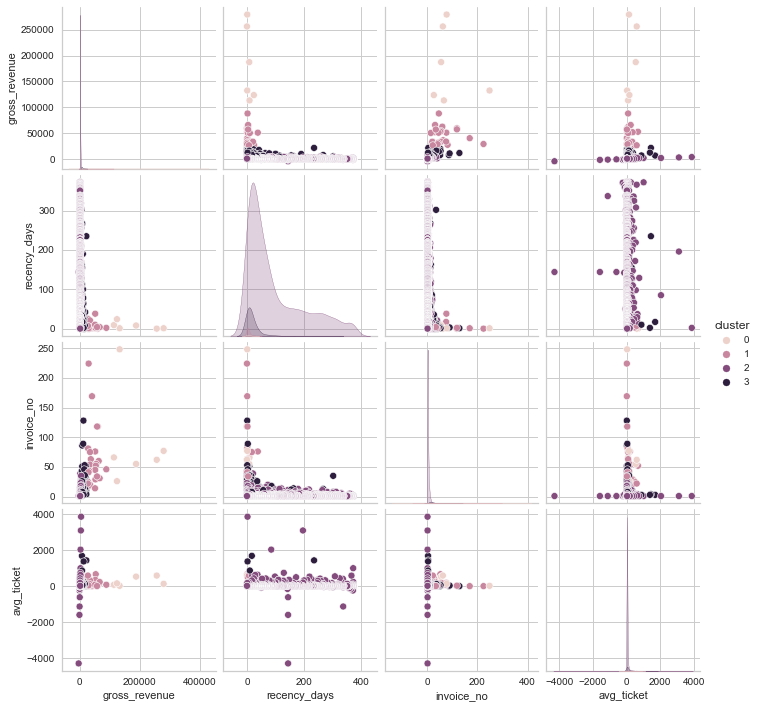

In [70]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

## 9.3. UMAP

## 9.4 Cluster Profile

In [63]:
#number of customer
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id']/df_cluster['customer_id'].sum())

#average gross revenue
df_avg_gross_revenue = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

#average recency days
df_avg_recency_day = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_day, how='inner', on='cluster')

#average invoice_no
df_avg_invoice_no = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no
0,0,4335,99.153705,1372.577826,92.257901,4.614533
1,1,6,0.137237,182181.981667,7.166667,89.000000
2,2,31,0.709058,40543.517742,13.290323,53.290323


# 3.0 Variable Filtering